Unsupervised Learning
======

In earlier labs we learned how to use linear regression to study whether certain features are significant in explaining and predicting an observed outcome. Then we used ensemble methods to refine our predictions. 

In this notebook, we shift the focus from prediction to pattern finding. 

Why care about pattern finding?
------

The reality is that most available data in the world is unlabelled and we just want to find patterns in the data.

That's where unsupervised learning comes in! Unsupervised learning methods are a set of techniques designed to <i>explore</i> the data rather than predict outcomes. There are many unsupervised learning methods but the most commonly-used method is [cluster analysis](https://en.wikipedia.org/wiki/Cluster_analysis) or more commonly called clustering.


Here is what we'll be doing in this notebook:

1. Load data and packages
1. Create clusters with k-means algorithm
1. Validate our model with elbow method and silhouette method
1. Evaluate our results

What is Cluster Analysis?
-----

Conducting cluster analysis is what it sounds like: partitioning your data into sub-groups (<b>clusters</b>) based on similar characteristics and then analyzing these clusters of similar observations. Clustering is an intuitive and visual way to understand the various natural <b>sub-groups</b> or <b>segments</b> that make up the population of your data.

In this lab, we'll walk through a few examples of how to use K-means clustering to <b>partition</b> or <b>segment</b> the Kiva data into clusters.

Introduction to k-means
------

TODO:

https://en.wikipedia.org/wiki/K-means_clustering


So how we do clustering?
-----

K-means clustering are formed by:

1. Observations are <i>randomly assigned</i> to a cluster
2. The center point of these <i>random</i> groups is determined
3. Observations are reassigned to a cluster where the center is closest to them
4. New center points of clusters are determined
5. Observations are reassigned to a cluster where the center is closest to them
6. New center points of clusters are determined
7. ...
8. The process repeats until no observations shuffle around anymore, and each observation is assigned to exactly one cluster

In other words, until the distance beween an observation and their closest center point is minimized, observations are constantly being reassigned to clusters.

While this process is computationally intense to do by hand, the <b>sklearn</b> K-means package is simple to use and does the computational heavy-lifting for you:

K-means Example
-----

![](http://shabal.in/visuals/kmeans/left.gif)

[Source](http://shabal.in/visuals/kmeans/2.html)

Let's import the relevant packages to start coding:

In [2]:
reset -fs

In [3]:
# For opening the data files
import os
from zipfile import ZipFile

# Data manipulation packages
import pandas as pd
import numpy as np

# Processing data module
from sklearn import preprocessing

# K-Means clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import cluster
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq

# Import packages for Silhouette testing 
from sklearn.metrics import silhouette_samples, silhouette_score

# Import packages for plotting the clusters
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.cm as cm

# Places the plots in the Jupyter Notebook
%matplotlib inline

# Keep everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)

In [6]:
# Load data
path = '../data/'
# filename = 'df_abridged' # Has few columns
filename = 'df' # Has more columns

df = pd.read_csv(path+filename+'.csv',
                 low_memory=False,
                 index_col=0)

# Normalize column names
df.columns = [c.lower().replace('.', '_').replace(' ', '_')
                 for c in df.columns]

It is always to take a peak at the data

In [7]:
df.head(n=2)

,unnamed:_0_1,unnamed:_0_1_1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description_languages,description_texts_en,description_texts_es,description_texts_fr,description_texts_ru,funded_amount,funded_date,id,image_id,image_template_id,journal_totals_bulkentries,journal_totals_entries,lender_count,loan_amount,location_country,location_country_code,location_geo_level,location_geo_pairs,location_geo_type,location_town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms_disbursal_amount,terms_disbursal_currency,terms_disbursal_date,terms_loan_amount,terms_local_payments,...,themes,translator_byline,translator_image,use,video_id,video_thumbnailimageid,video_title,video_youtubeid,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image_id,partner_image_template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,funded_datetime,planned_expiration_datetime,dispursal_datetime,number_of_loans,dispersal_date,posted_year,posted_month,time_to_fund
0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-10T07:00:00Z', 'amount'...",...,NaN,Julie Keaton,892591.0,to purchase more tea leaves to sell to the tea...,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:40:03,NaN,2017-06-08 00:40:03,2017-04-03 07:00:00,1,2017-04-03,2017,5,NaN
1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-09T07:00:00Z', 'amount'...",...,NaN,Morena Calvo,1832928.0,to buy timber to make more furniture for his e...,NaN,NaN,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272.0,1.0,21.165398,1948.0,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375.0,http://www.eclof-kenya.org/,2017-05-09 00:30:05,NaN,2017-06-08 00:30:05,2017-04-03 07:00:00,1,2017-04-03,2017,5,NaN


In [8]:
f"There are {df.shape[0]:,} rows in the dataframe."

'There are 118,316 rows in the dataframe.'

In [9]:
# Check out the dataframe columns
print(*df.columns, sep='\n')

unnamed:_0_1
unnamed:_0_1_1
activity
basket_amount
bonus_credit_eligibility
borrowers
currency_exchange_loss_amount
description_languages
description_texts_en
description_texts_es
description_texts_fr
description_texts_ru
funded_amount
funded_date
id
image_id
image_template_id
journal_totals_bulkentries
journal_totals_entries
lender_count
loan_amount
location_country
location_country_code
location_geo_level
location_geo_pairs
location_geo_type
location_town
name
partner_id
payments
planned_expiration_date
posted_date
sector
status
tags
terms_disbursal_amount
terms_disbursal_currency
terms_disbursal_date
terms_loan_amount
terms_local_payments
terms_loss_liability_currency_exchange
terms_loss_liability_currency_exchange_coverage_rate
terms_loss_liability_nonpayment
terms_repayment_interval
terms_repayment_term
terms_scheduled_payments
themes
translator_byline
translator_image
use
video_id
video_thumbnailimageid
video_title
video_youtubeid
borrower_count
partner_average_loan_size_percent_

------

Now that we have our data set up, we can begin partitioning our data into clusters based on a few features. Let's think about a few of these.

As a potential borrower or lender, what would be interesting to explore? 

In the previous notebooks, we explored a number of interesting ideas, including how much a borrower should ask to borrow, the time it takes to fund a loan, and what features can influence the loan amount. If we partition borrowers into distinct groups based on how quickly they can fund a loan, will we be able to learn anything about these groups of borrowers?

The k-means algorithm processes numeric values. Let's prepare a few interesting numeric features for analysis:

In [10]:
# XXX: This might just cargo coding from Python 2
# # Convert potential numeric columns of interest to float types
# df['funded_amount'] = df['funded_amount']*1.0
# df['lender_count'] = df['lender_count']*1.0
# df['loan_amount'] = df['loan_amount']*1.0
# df['borrower_count'] = df['borrower_count']*1.0
# df['days_to_fund'] = df['days_to_fund']*1.0

In [27]:
# Keep only relevant columns
relavant_colums = ['funded_amount', 
#                    'lender_count', 
                   'loan_amount']
#                    'borrower_count']

df = df[relavant_colums] 

In [28]:
# Take a peek at summary statistics
df.describe()

,funded_amount,loan_amount
count,118316.000000,118316.000000
mean,473.439771,495.159784
std,676.663803,704.079168
min,0.000000,25.000000
25%,250.000000,250.000000
50%,350.000000,375.000000
75%,600.000000,600.000000
max,50000.000000,50000.000000


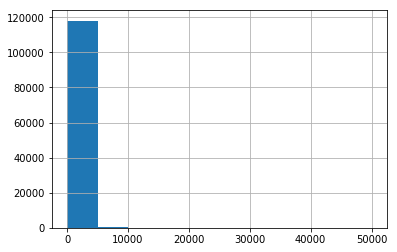

In [55]:
df.loan_amount.hist();

In [ ]:
k_means_labels

Now we're ready to run the k-means algorithm:

Let's take quick peek at the [scikit-learn's documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [37]:
# Take KMeans class, initialize and fit it our data
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans = fit(df)

In [42]:
k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_

In [58]:
len(df.iloc[k_means_labels==0])

118237

In [ ]:
plt.scatter(df[:, 0], X1[:, 1], marker='o', c=Y1,
            s=25, edgecolor='k')

/Users/brian/anaconda3/envs/good/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """
/Users/brian/anaconda3/envs/good/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  
/Users/brian/anaconda3/envs/good/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  return None  # converted to True where accessed in figure.py,


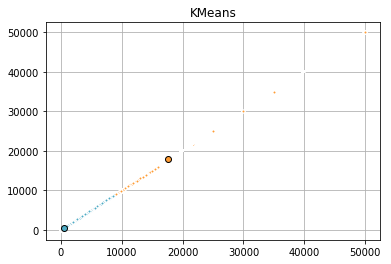

In [45]:
# Plot result

colors = ['#4EACC5', '#FF9C34', '#4E9A06']
plt.figure()
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(df[my_members], 
             df[my_members], 
             'w',
             markerfacecolor=col, 
             marker='.')
    plt.plot(cluster_center[0],
             cluster_center[1], 
             'o',
             markerfacecolor=col,
             markeredgecolor='k', 
             markersize=6)
plt.title('KMeans')    
plt.grid(True)
plt.show()

# Validating Our Cluster Analysis

Let's break down step by step what the above chunk of code is actually doing and assess some of the factors worth considering as you form a cluster analysis.

# Determining the number of features to include

In [16]:
#Create clusters based on days to fund, loan amount, and repayment terms only
loans_array = df.query("days_to_fund >= 0")[['days_to_fund', 'loan_amount', 'terms.repayment_term']].as_matrix()

UndefinedVariableError: name 'days_to_fund' is not defined

Here, we are initially creating clusters based only on the days to fund, loan amount, and repayment terms, but we can certainly add more features to "loans_array". This would make our groups more granular.



# Determining k

In [17]:
#Initialize and run k-means algorithm
centroids,_ = kmeans(loans_array, 3)
idx,_ = vq(loans_array,centroids)

All the first line here does is arbitrarily set the number of clusters to form to be 3. But determining the appropriate number of clusters (k) is actually one of the most challenging parts of cluster analysis. Because the number of clusters will always vary depending on your data and what you are trying to assess, there is no hard and fast rule for what the value of k should be. 

<b>Why does determining k matter? Is it possible to have too many clusters? Or too few clusters?</b>

The number of groups you choose to partition in your data directly influences the results you'll find. In most areas of data analysis, it's attractive to take as granular an approach as possible, but having too many clusters can be counterproductive. Think about these extreme examples: 

1. Treating each data point as its own cluster
2. Treating all your data points as one cluster

Neither of these will tell you anything new about your data! Rather, clustering is most effective when observations in the same cluster are very similar to each other. Relatedly, we want observations in different clusters to be as different from each other as possible.

<b>So how can I validate my choice of k?</b>

There are many statistical methods proposed to help determine k, including <b><a href="http://cs.fit.edu/~pkc/papers/ictai04salvador.pdf">the elbow method</a></b>, <b><a href="https://cs.fit.edu/~pkc/classes/ml-internet/silhouette.pdf">the silhouette method</a></b>, the information criterion approach, cross validation, and more. 

The <b>elbow method</b> is a simple, intuitive check. What the elbow method does is this:

1. Run the k-means algorithm over your dataset for a range of values (<i>e.g.,</i> let k be between 1 and 10 inclusive)
2. For each value of k, calculate the sum of squared errors (SSE)
3. If we see an "elbow" in our plotted check, then that marks the optimal value of k

Check out a Python implementation of the elbow method on our cluster feature choice (days to fund, loan amount, and repayment terms) below:

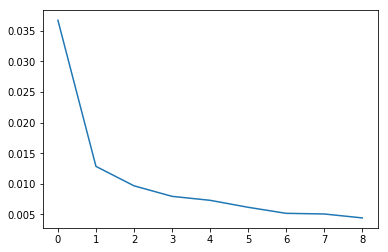

In [18]:
cluster_array = [cluster.vq.kmeans(loans_array, i) for i in range(1,10)]

plt.plot([var for (cent,var) in cluster_array])
plt.show()

<b>Limitations of the Elbow Method</b>

The elbow method is a valid check when data is actually reasonably clustered based on the selected feature set (in our case: days to fund, loan amount, and repayment terms). But it's possible that your data may not be very clustered. For example, we actually see a fairly smooth curve rather than a sharply-defined "elbow" in the plot above, so it's not obvious what the optimal vaue of k is.

The Silhouette Method
----

The <b>Silhouette Coefficient</b> (also known as "Silhouette Score") is a measure of how well samples are clustered with samples that are similar to themselves. 

Clustering models with a high Silhouette Coefficient are "dense" (samples in the same cluster are similar to each other) and "well separated" (samples in different clusters are not very similar to each other). High Silhouette Coefficients are desirable.

<b>Calculating the Silhouette Coefficient</b>

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. Mathematically, the Silhouette Coefficient for a sample is <b>(b - a) / max(a, b)</b>, where b is the distance between a sample and the nearest cluster that the sample is not a part of. 

The best value for a Silhouette Coefficient to take on is 1 and the worst is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

Check out the code and plots below for an implementation of the silhouette method using the sklearn package on a sample of the Kiva data:

For n_clusters = 2 The average silhouette_score is : 0.913094866344


NameError: name 'X' is not defined

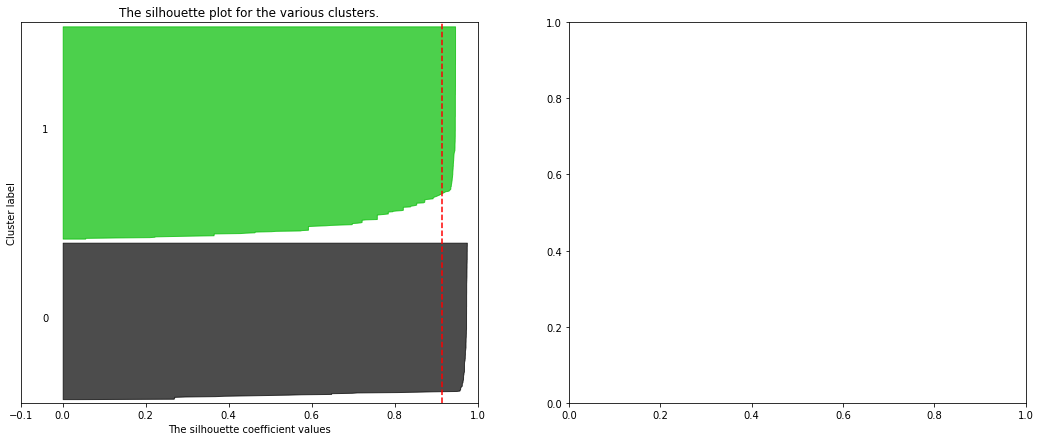

In [19]:
# Silhouette method

# Use a sample of the data, full dataset is too much for a small machine
X_sil = loans_array[1:1000,0:5]

# Number of clusters to check
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_sil) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_sil)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_sil, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_sil, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In our code, the Silhouette Coefficient is the mean across all the samples. As we see from the plots above, the Silhouette Coefficient is closest to 1.0 when n_clusters = 2. When there are only two clusters, we see that the points are closer within their clusters than to other clusters. 

Now that we have a better understanding of an appropriate value for k, let's update our number of clusters assignment:

In [ ]:
#Initialize and run k-means algorithm
#Recall that our loans array currently has three features: days to fund, loan amount, and repayment terms
centroids,_ = kmeans(loans_array, 2) #set number of clusters to 2
idx,_ = vq(loans_array, centroids)

#Plot our clusters
plot(loans_array[idx==0,0],loans_array[idx==0,1],'ob', #first cluster points
     loans_array[idx==1,0],loans_array[idx==1,1],'or') #second cluster points

plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
show()

Evaluating the plot above, we can easily see that the loans are actually not that effectively clustered with our selected features - see how distant some observations are from their centroid (marked in green).

That is, we weren't able to create particularly meaningful groups based on days to fund, loan amount, and repayment terms. We should re-evaluate our cluster analysis formation; it's possible that one of our features is noisy. Let's see what happens when we take out days to fund completely:

In [ ]:
#Create clusters based on loan amount and repayment terms only (remove days to fund)
loans_array_2 = df[['loan_amount', 'terms.repayment_term']].as_matrix()

#Initialize and run k-means algorithm
centroids,_ = kmeans(loans_array_2, 2)
idx,_ = vq(loans_array_2, centroids)

#Plot our clusters
plot(loans_array_2[idx==0,0],loans_array_2[idx==0,1],'ob', #first cluster points
     loans_array_2[idx==1,0],loans_array_2[idx==1,1],'or') #second cluster points

plot(centroids[:,0],centroids[:,1],'sg',markersize=8)
show()

Here, when we form clusters removing the days to fund feature, we see much tighter clusters formed.

# Homework

1. Apply the K-means clustering algorithm with a new set of features to cluster by, making sure to validate your assumptions
2. Create categorical variables based on these natural groups you were able to identify

Further study
-----

Greater theoretical detail described [here](https://www-users.cs.umn.edu/~kumar/dmbook/ch8.pdf). 

There are many other clustering methods, including: 

1. Hierarchical clustering
2. K-means clustering
3. Expectation-maximization clustering
4. Graph-theoretic clustering
5. Fuzzy clustering

----
Extra Material
-----

Pre-Processing: Feature Scaling
-----

Each of these features can take a very different range of values. 

Because the k-means algorithm can be sensitive to these differences, let's first pre-process our data and standardize our values:

In [12]:
loans_array = preprocessing.normalize(df,
                                      copy=False)

<b>Is it possible to include too many features?</b>

Yes it is! The K-means algorithm is computationally demanding algorithm, so there is a cost associated with adding too many features.

In [ ]:
# Create a new variable that models the time it takes for a loan to get funded
df['time_to_fund'] = pd.to_datetime(df['funded_datetime']) - pd.to_datetime(df['posted_datetime'])
df['days_to_fund'] = df.time_to_fund.dt.days

<br>
<br> 
<br>

----